# Titanic - Machine Learning from Disaster

https://www.kaggle.com/competitions/titanic

https://www.kaggle.com/competitions/titanic/data

Sources of inspiration:
- https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial/notebook?scriptVersionId=27280410
- https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb

In [1]:
import os

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import seaborn as sns
sns.set(style="darkgrid")

from sklearn.preprocessing import (
    LabelEncoder,
    FunctionTransformer,
    OrdinalEncoder,
    OneHotEncoder,
    StandardScaler
)
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

RANDOM_STATE = 42

## Download dataset

In [2]:
import kagglehub
path = kagglehub.competition_download("titanic")
path

'/home/martin/.cache/kagglehub/competitions/titanic'

In [3]:
train_data = pd.read_csv(os.path.join(path, "train.csv"))
train_data.shape

(891, 12)

In [4]:
test_data = pd.read_csv(os.path.join(path, "test.csv"))
test_data.shape

(418, 11)

## Explore data

In [5]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

# The goal of the competition is to predict Survival based on test_data.
# We wouldn't have that kind of luxury in real world and we would stay away from test_data as far as we can (so that we can prepare for production data).
# Here however, we should include the test_data, in exploration, augmentation and feature creation (so that we are best prepared for the test data).
all_data = concat_df(train_data, test_data)

### Survival rate based on Sex

In [8]:
women = train_data.loc[train_data.Sex == 'female']["Survived"]
rate_women = sum(women)/len(women)

print("% of women who survived:", rate_women)

% of women who survived: 0.7420382165605095


In [9]:
men = train_data.loc[train_data.Sex == 'male']["Survived"]
rate_men = sum(men)/len(men)

print("% of men who survived:", rate_men)

% of men who survived: 0.18890814558058924


## Prepare the Data for Machine Learning Algorithms

### Feature Engineering

#### Title

As mentioned in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=58),
title *Master* tells us that a person is a small boy. Also, we can learn whether woman is married or unmarried.

In [10]:
all_data["Title"] = (
    all_data["Name"].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
)

# This should retain information for most prevalant ones but remove the outliers
all_data["Title"] = (
    all_data["Title"]
    .replace(
        ["Mrs", "Lady", "Mme", "the Countess", "Dona"],
        "Married woman",
    )
    .replace(["Miss", "Mlle", "Ms"], "Unmarried woman")
    .replace(
        ["Dr", "Col", "Major", "Jonkheer", "Capt", "Sir", "Don", "Rev"],
        "Dr/Military/Noble/Clergy",
    )
)

In [11]:
all_data["Title"].value_counts()

Title
Mr                          757
Unmarried woman             264
Married woman               201
Master                       61
Dr/Military/Noble/Clergy     26
Name: count, dtype: int64

#### Families

In [12]:
all_data["Parch"].value_counts()

Parch
0    1002
1     170
2     113
3       8
5       6
4       6
6       2
9       2
Name: count, dtype: int64

In [13]:
all_data["Family_Size"] = all_data["SibSp"] + all_data["Parch"] + 1

In [14]:
all_data["Family_Size"].value_counts()

Family_Size
1     790
2     235
3     159
4      43
6      25
5      22
7      16
11     11
8       8
Name: count, dtype: int64

In [15]:
family_map = {
    1: "Alone",
    2: "Small",
    3: "Small",
    4: "Small",
    5: "Medium",
    6: "Medium",
    7: "Large",
    8: "Large",
    11: "Large",
}
all_data["Family_Size_Grouped"] = all_data["Family_Size"].map(family_map)

In [16]:
all_data["Family_Size_Grouped"].value_counts()

Family_Size_Grouped
Alone     790
Small     437
Medium     47
Large      35
Name: count, dtype: int64

#### Ticket Frequency

As mentioned in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=53),
passangers who travel alone have the lowest survival rate and those with more people on one ticket higher.

In [17]:
all_data["Ticket_Frequency"] = all_data.groupby("Ticket")["Ticket"].transform("count")

### Missing values

In [18]:
all_data.isnull().sum()

Age                     263
Cabin                  1014
Embarked                  2
Fare                      1
Name                      0
Parch                     0
PassengerId               0
Pclass                    0
Sex                       0
SibSp                     0
Survived                418
Ticket                    0
Title                     0
Family_Size               0
Family_Size_Grouped       0
Ticket_Frequency          0
dtype: int64

#### Age

After testing few combinations, this grouping seems to bring the best results.
Tested with MSRE.

In [19]:
all_data["Age"] = all_data.groupby(['Pclass', 'Title'])["Age"].transform(lambda x: x.fillna(x.median()))

Grouped based on survival rates.

In [20]:
all_data["Age_Grouped"] = pd.qcut(all_data["Age"], 10, duplicates="drop")

In [21]:
all_data["Age_Grouped"].value_counts()

Age_Grouped
(23.0, 26.0]     249
(26.0, 30.0]     150
(0.169, 16.0]    142
(40.7, 48.0]     142
(16.0, 19.0]     139
(19.0, 23.0]     137
(34.0, 40.7]     123
(48.0, 80.0]     120
(30.0, 34.0]     107
Name: count, dtype: int64

#### Cabin

**New Deck Feature**

Cabin alone doesn't give us a lot of information, but we can extract Deck from that feature which better correlates with other features.

**Missing Cabin values**

As noted in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=22),
people with missing Cabin value have low survival rate, so it can be a good feature and let's do the same and create special category for them (instead of replacing it with most common).

In [22]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
all_data["Deck"] = all_data["Cabin"].apply(lambda s: s[0] if pd.notnull(s) else 'M')

**Deck T**

As noted in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=22),
"There is one person on the boat deck in T cabin and he is a 1st class passenger. T cabin passenger has the closest resemblance to A deck passengers so he is grouped with A deck".

In [23]:
# Passenger in the T deck is changed to A
idx = all_data[all_data["Deck"] == 'T'].index
all_data.loc[idx, "Deck"] = 'A'

Deck grouping is done based on PClass grouping and survival rate.

In [24]:
all_data["Deck_Grouped"] = (
    all_data["Deck"]
    .replace(["A", "B", "C"], "ABC")
    .replace(["D", "E"], "DE")
    .replace(["F", "G"], "FG")
)

In [25]:
all_data["Deck_Grouped"].value_counts()

Deck_Grouped
M      1014
ABC     182
DE       87
FG       26
Name: count, dtype: int64

#### Embarked

Just replace NaN with most common value.

In [26]:
all_data["Embarked"] = all_data["Embarked"].fillna(all_data["Embarked"].mode().iloc[0])

In [27]:
all_data.isnull().sum()

Age                       0
Cabin                  1014
Embarked                  0
Fare                      1
Name                      0
Parch                     0
PassengerId               0
Pclass                    0
Sex                       0
SibSp                     0
Survived                418
Ticket                    0
Title                     0
Family_Size               0
Family_Size_Grouped       0
Ticket_Frequency          0
Age_Grouped               0
Deck                      0
Deck_Grouped              0
dtype: int64

#### Fare

In [28]:
# Filling the missing values in Fare with the medians of related groups
all_data["Fare"] = all_data.groupby(['Pclass', 'Parch', 'SibSp'])["Fare"].transform(lambda x: x.fillna(x.median()))

In [29]:
all_data.isnull().sum()

Age                       0
Cabin                  1014
Embarked                  0
Fare                      0
Name                      0
Parch                     0
PassengerId               0
Pclass                    0
Sex                       0
SibSp                     0
Survived                418
Ticket                    0
Title                     0
Family_Size               0
Family_Size_Grouped       0
Ticket_Frequency          0
Age_Grouped               0
Deck                      0
Deck_Grouped              0
dtype: int64

As mentioned in [Titanic - Advanced Feature Engineering Tutorial](https://www.kaggle.com/code/gunesevitan/titanic-advanced-feature-engineering-tutorial?scriptVersionId=27280410&cellId=47),
13 should give use enough information (as proven by having similar correlation with "Survived" as logarithmic Fare).

In [30]:
all_data["Fare_Grouped"] = pd.qcut(all_data['Fare'], 13)
all_data["Fare_Grouped"] = LabelEncoder().fit_transform(all_data["Fare_Grouped"])

In [31]:
# TODO: compare if it is better to use "Fare_Log" or "Fare_Grouped" (intuitively I would say that Random Forest should be allowed to slice continuous values itself)
# Fare is skewed slightly to the left so log function will fix it to resemble bell curve (ML models work with that better).
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
all_data["Fare_Log"] = log_transformer.transform(all_data[["Fare"]])

/home/martin/miniconda/lib/python3.12/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


#### Survival correlation with new features

In [32]:
all_data_copy = all_data.copy()

all_data_copy["Deck_Num"] = LabelEncoder().fit_transform(all_data_copy["Deck"])
all_data_copy["Deck_Grouped_Num"] = LabelEncoder().fit_transform(all_data_copy["Deck_Grouped"])
all_data_copy["Cabin_Num"] = LabelEncoder().fit_transform(all_data_copy["Cabin"])
all_data_copy["Embarked_Num"] = LabelEncoder().fit_transform(all_data_copy["Embarked"])
all_data_copy["Sex_Num"] = LabelEncoder().fit_transform(all_data_copy["Sex"])
all_data_copy["Title_Num"] = LabelEncoder().fit_transform(all_data_copy["Title"])
all_data_copy["Ticket_Num"] = LabelEncoder().fit_transform(all_data_copy["Ticket"])
all_data_copy["Family_Size_Grouped_Num"] = LabelEncoder().fit_transform(all_data_copy["Family_Size_Grouped"])
all_data_copy["Age_Grouped_Num"] = LabelEncoder().fit_transform(all_data_copy["Age_Grouped"])

corr_matrix = all_data_copy.corr(numeric_only=True)
corr_matrix["Survived"].sort_values(ascending=False)

Survived                   1.000000
Fare_Log                   0.325452
Fare_Grouped               0.321206
Fare                       0.257307
Family_Size_Grouped_Num    0.246084
Parch                      0.081629
Ticket_Frequency           0.064962
Family_Size                0.016639
PassengerId               -0.005007
Age_Grouped_Num           -0.025773
SibSp                     -0.035322
Age                       -0.059421
Title_Num                 -0.111201
Ticket_Num                -0.166734
Embarked_Num              -0.167675
Cabin_Num                 -0.253406
Deck_Num                  -0.290485
Deck_Grouped_Num          -0.297898
Pclass                    -0.338481
Sex_Num                   -0.543351
Name: Survived, dtype: float64

## Train and evaluate different models

In [76]:
interval_pipeline = Pipeline(
    [
        ("ordinal_encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

In [33]:
num_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

In [34]:
cat_pipeline = Pipeline(
    [
        ("ordinal_encoder", OrdinalEncoder()),
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("cat_encoder", OneHotEncoder(sparse_output=False)),
    ]
)

In [78]:
interval_attribs = ["Fare_Grouped", "Age_Grouped"]
num_attribs = ["SibSp", "Parch", "Ticket_Frequency"]
cat_attribs = ["Pclass", "Sex", "Embarked", "Deck_Grouped", "Title", "Family_Size_Grouped"]

preprocess_pipeline = ColumnTransformer([
        ("interval", interval_pipeline, interval_attribs),
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ], remainder='passthrough', verbose_feature_names_out=False)

In [80]:
transformed_data = preprocess_pipeline.fit_transform(all_data)

transformed_data_df = pd.DataFrame(
    transformed_data,
    columns=preprocess_pipeline.get_feature_names_out(),
    index=all_data.index,
).drop(["Cabin", "Name", "Ticket", "Fare_Log", "Fare", "Family_Size", "Deck", "Age"], axis=1)

train_data, test_data = divide_df(transformed_data_df)

X = train_data.drop(["Survived", "PassengerId"], axis=1)
y = train_data["Survived"].copy().astype("int64")

X_test = test_data.drop(["PassengerId"], axis=1)

In [81]:
X.columns

Index(['Fare_Grouped', 'Age_Grouped', 'SibSp', 'Parch', 'Ticket_Frequency',
       'Pclass_0.0', 'Pclass_1.0', 'Pclass_2.0', 'Sex_0.0', 'Sex_1.0',
       'Embarked_0.0', 'Embarked_1.0', 'Embarked_2.0', 'Deck_Grouped_0.0',
       'Deck_Grouped_1.0', 'Deck_Grouped_2.0', 'Deck_Grouped_3.0', 'Title_0.0',
       'Title_1.0', 'Title_2.0', 'Title_3.0', 'Title_4.0',
       'Family_Size_Grouped_0.0', 'Family_Size_Grouped_1.0',
       'Family_Size_Grouped_2.0', 'Family_Size_Grouped_3.0'],
      dtype='object')

### Logistic Regression

In [82]:
lg_model = LogisticRegression(random_state=RANDOM_STATE)
lg_model.fit(X, y)

LogisticRegression(random_state=42)

### Decision Tree

In [83]:
dtc_model = DecisionTreeClassifier(random_state=RANDOM_STATE)
dtc_model.fit(X, y)

DecisionTreeClassifier(random_state=42)

### Random forest classifier

In [84]:
rfc_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=RANDOM_STATE)
rfc_model.fit(X, y)

RandomForestClassifier(max_depth=5, random_state=42)

In [85]:
feature_importances = rfc_model.feature_importances_

importances = pd.DataFrame(
    zip(X, feature_importances),
    columns=["Feature", "Importance"]
).sort_values(by="Importance", ascending=False)


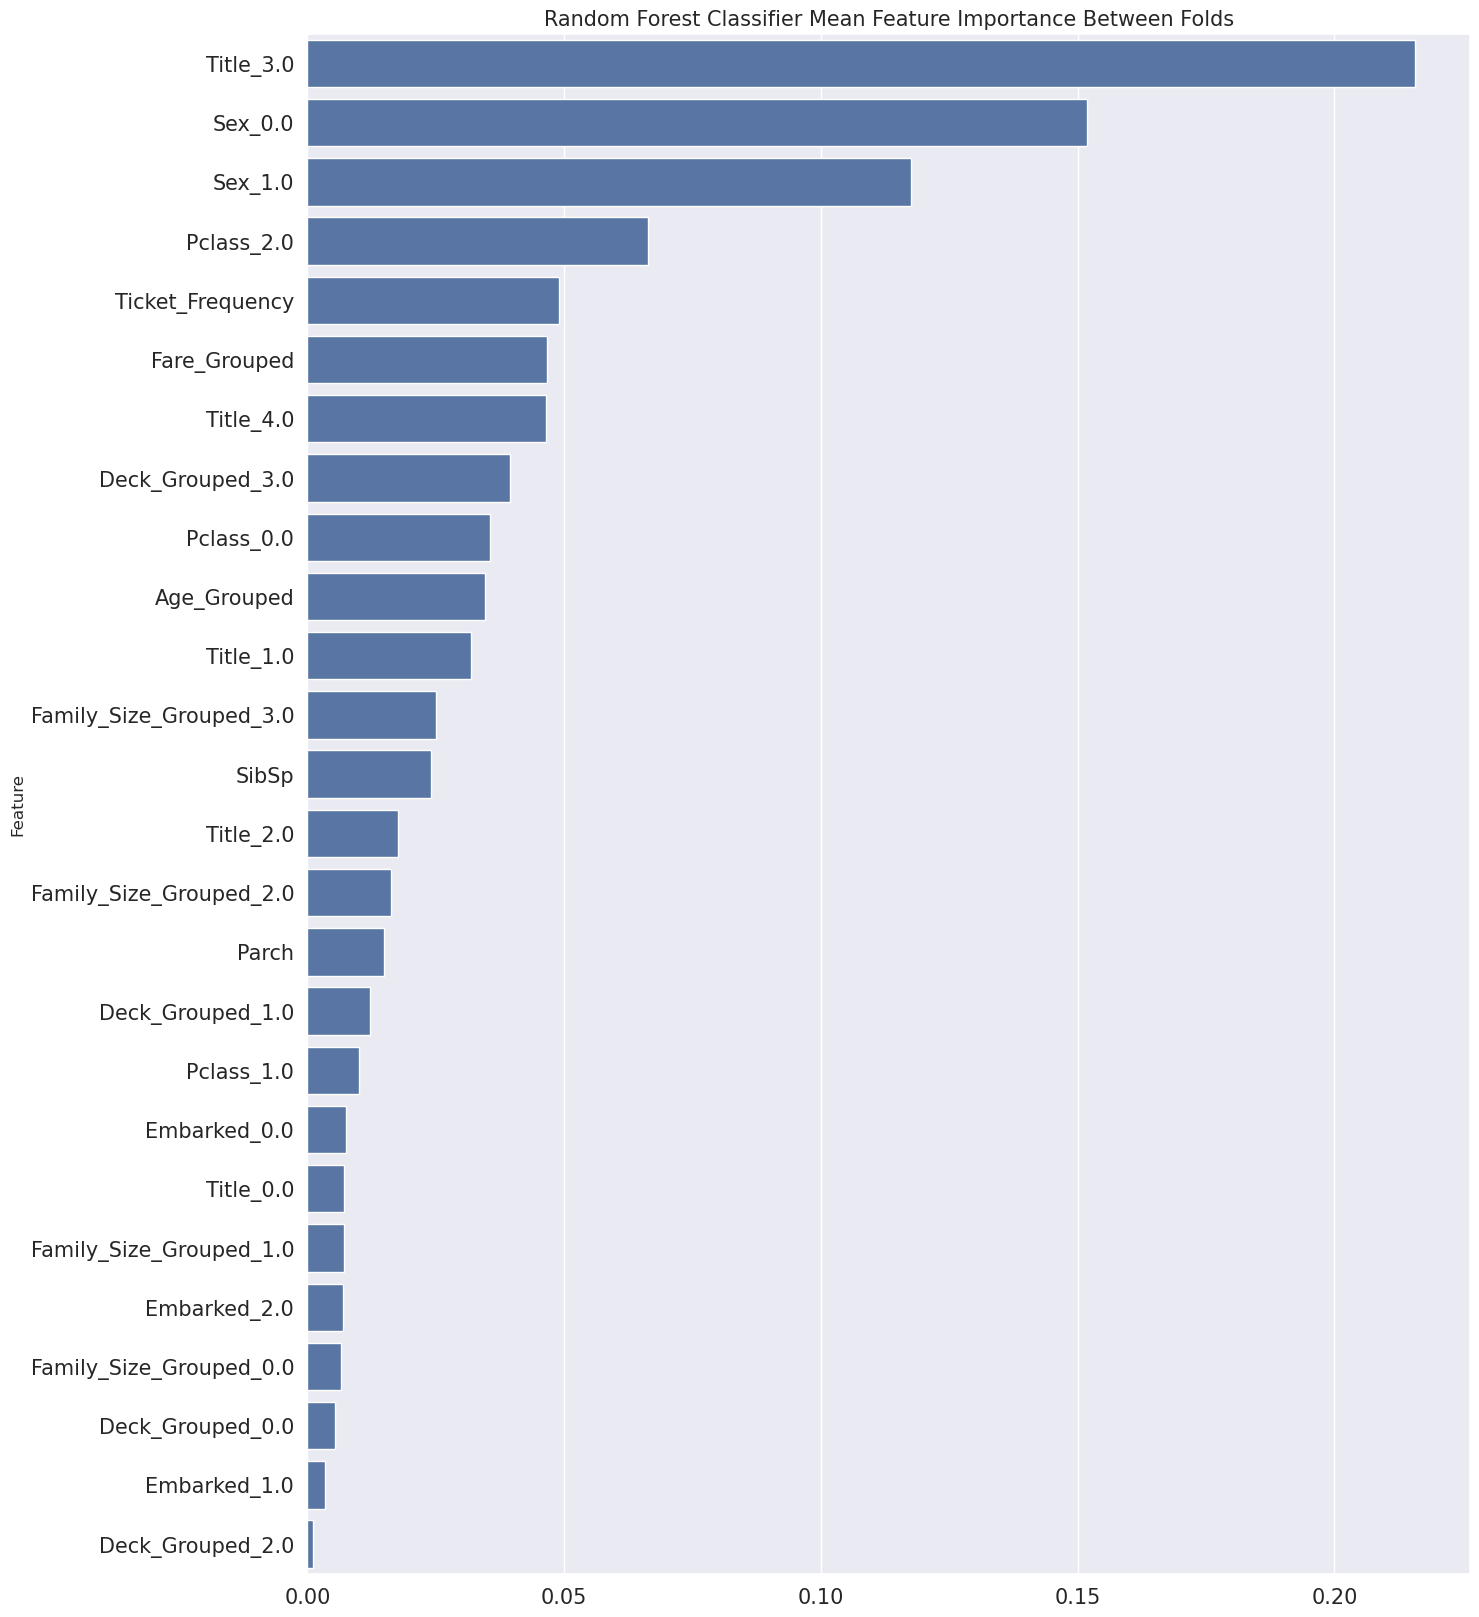

In [86]:
plt.figure(figsize=(15, 20))
sns.barplot(x='Importance', y='Feature', data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

### Support Vector Classifier

In [87]:
svc_model = SVC(gamma="auto", random_state=RANDOM_STATE)
svc_model.fit(X, y)

SVC(gamma='auto', random_state=42)

### K-Nearest Neighbors Classifier

In [88]:
knc_model = KNeighborsClassifier(n_neighbors=3)
knc_model.fit(X, y)

KNeighborsClassifier(n_neighbors=3)

### Comparision

In [89]:
lg_scores = cross_val_score(lg_model, X, y, cv=10, scoring="accuracy")
print(f"Logistic Regression Mean: {lg_scores.mean()}")

dtc_scores = cross_val_score(dtc_model, X, y, cv=10, scoring="accuracy")
print(f"Decision Tree Mean: {dtc_scores.mean()}")

rfc_scores = cross_val_score(rfc_model, X, y, cv=10, scoring="accuracy")
print(f"Random Forest Mean: {rfc_scores.mean()}")

svc_scores = cross_val_score(svc_model, X, y, cv=10, scoring="accuracy")
print(f"SVM Mean: {svc_scores.mean()}")

knc_scores = cross_val_score(knc_model, X, y, cv=10, scoring="accuracy")
print(f"K-Nearest Neighbors Mean: {knc_scores.mean()}")

Logistic Regression Mean: 0.8294257178526842
Decision Tree Mean: 0.7845692883895131
Random Forest Mean: 0.8338951310861423
SVM Mean: 0.8327715355805243
K-Nearest Neighbors Mean: 0.8025593008739076


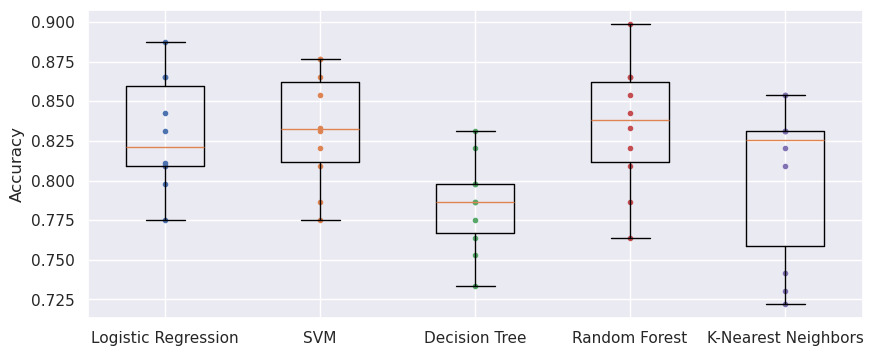

In [90]:
plt.figure(figsize=(10, 4))
plt.plot([1] * 10, lg_scores, ".")
plt.plot([2] * 10, svc_scores, ".")
plt.plot([3] * 10, dtc_scores, ".")
plt.plot([4] * 10, rfc_scores, ".")
plt.plot([5] * 10, knc_scores, ".")
plt.boxplot(
    [lg_scores, svc_scores, dtc_scores, rfc_scores, knc_scores],
    tick_labels=(
        "Logistic Regression",
        "SVM",
        "Decision Tree",
        "Random Forest",
        "K-Nearest Neighbors"
    ),
)
plt.ylabel("Accuracy")
plt.show()

### Hyperparameter tuning

In [97]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


class DummyEstimator(BaseEstimator):
    def fit(self):
        pass

    def score(self):
        pass


# Create a pipeline
pipe = Pipeline([("clf", DummyEstimator())])  # Placeholder Estimator

# Candidate learning algorithms and their hyperparameters
search_space = [
    {
        "clf": [LogisticRegression(random_state=RANDOM_STATE)],
        "clf__penalty": ["l1", "l2"],
        "clf__C": np.logspace(0, 4, 10),
    },
    {
        "clf": [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        "clf__criterion": ["gini", "entropy"],
    },
    {
        "clf": [KNeighborsClassifier()],
        "clf__n_neighbors": randint(low=1, high=31),
    },
    {
        "clf": [SVC(random_state=RANDOM_STATE)],
        "clf__C": [0.1, 1, 10, 100, 1000],
        "clf__gamma": [1, 0.1, 0.01, 0.001, 0.0001],
        "clf__kernel": ["rbf"],
    },
    {
        "clf": [
            RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=1)
        ],
        "clf__n_estimators": randint(low=50, high=2000),
        "clf__max_depth": randint(low=3, high=10),
        "clf__max_features": randint(low=2, high=20),
        "clf__criterion": ["gini", "entropy"],
        "clf__min_samples_split": randint(low=3, high=7),
        "clf__min_samples_leaf": randint(low=3, high=7),
        "clf__oob_score": [True, False],
    },
]


NUM_OF_ITERATIONS = 50 # best results with 50 with no improvement above that - setting 5 so that it is quick when we don't need it
rnd_search = RandomizedSearchCV(
    pipe, search_space, n_iter=NUM_OF_ITERATIONS, cv=3, scoring="accuracy", random_state=RANDOM_STATE
)

rnd_search.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1446 out of 1446 | elapsed:    3.8s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 1226 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 1446 out of 1446 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concur

RandomizedSearchCV(cv=3, estimator=Pipeline(steps=[('clf', DummyEstimator())]),
                   n_iter=50,
                   param_distributions=[{'clf': [LogisticRegression(random_state=42)],
                                         'clf__C': array([1.00000000e+00, 2.78255940e+00, 7.74263683e+00, 2.15443469e+01,
       5.99484250e+01, 1.66810054e+02, 4.64158883e+02, 1.29154967e+03,
       3.59381366e+03, 1.00000000e+04]),
                                         'clf__penalty': ['l1', 'l2']},
                                        {...
                                         'clf__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f29f01caa20>,
                                         'clf__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f29ea728b30>,
                                         'clf__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f29f019ce60>,
                                         'clf__oob_score': [True, False]}],
                   random_state=42, scoring='accuracy')

In [103]:
rnd_search.best_score_

0.8350168350168351

In [104]:
rnd_search.best_params_

{'clf': RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1),
 'clf__criterion': 'entropy',
 'clf__max_depth': 6,
 'clf__max_features': 7,
 'clf__min_samples_leaf': 4,
 'clf__min_samples_split': 6,
 'clf__n_estimators': 1005,
 'clf__oob_score': True}

In [100]:
# Basic model still performs the best on the real data - might be that we are overfitting with hyperparameter optimizations
# final_model = rnd_search.best_estimator_
final_model = rfc_model

## Upload new submission

In [105]:
predictions = final_model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions.astype('int64')})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


| WARNING: Don't forget to change "changeId" so that we can track version of jupyter book this submission is from! |
| --- |

In [102]:
# In case we run this cell by accident, this script disables its execution - comment out to enable it again
%%script false --no-raise-error

from kaggle.api.kaggle_api_extended import KaggleApi

changeId = "e607e8a3f222672d408cee9cb87770446c6307a2"

api = KaggleApi()
api.authenticate()

# kaggle competitions submit -c titanic -f submission.csv -m "Message"
api.competition_submit(file_name="submission.csv", message=f"ChangeId: {changeId}", competition="titanic")

UsageError: Line magic function `%%script` not found.
